# Data Preprocessing

In [1]:
import os
import pickle 
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torch.autograd import Variable

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


# Creating dataframe

In [3]:
traindf = pd.read_csv("./model/103_train_1024.csv") 
traindf 

,image,label
0,310002054.png,1
1,370913041.png,1
2,370413083.png,1
3,371001371.png,1
4,330001403.png,1
...,...,...
10030,370301551.png,1
10031,320012121.png,1
10032,350002152.png,1
10033,320016122.png,1


In [4]:
validdf = pd.read_csv("./model/103_dev_1024.csv") 
validdf

,image,label
0,310005222.png,0
1,350006023.png,0
2,340006081.png,0
3,310002301.png,0
4,370801111.png,1
...,...,...
2504,370713171.png,1
2505,320001441.png,0
2506,370413094.png,1
2507,371001133.png,0


In [5]:
print('train pos:',len(traindf[traindf['label'] == 1]))
print('train  neg:',len(traindf[traindf['label'] == 0]))
print('sum: ',len(traindf[traindf['label'] == 1]) + len(traindf[traindf['label'] == 0]))

train pos: 5561
train  neg: 4474
sum:  10035


# Pytorch model

## Dataset

In [6]:
composed = transforms.Compose([
    transforms.Resize((256, 256)), #224
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])

class C0_Data(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.transforms = transforms
        self.dataframe = dataframe

    def __getitem__(self, idx):
        image = self.dataframe['image'][idx]
        label = self.dataframe['label'][idx]

        img_path = os.path.join('./103_photo_all_256/', image)
        img = Image.open(img_path) #.convert("RGB").crop((xmin, ymin, xmax, ymax))

        if self.transforms is not None:
            img = self.transforms(img)

        if label == 1:
            y = torch.tensor(1)
        else:
            y = torch.tensor(0)
    
        return img, y

    def __len__(self):
        return len(self.dataframe)

In [7]:
c0_dataset = C0_Data(traindf, composed)
len(c0_dataset)

10035

In [8]:
composed_dev = transforms.Compose([
    transforms.Resize((256, 256)), #224
    # #transforms.RandomRotation(degrees=15),
    # #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),
])

class C0_Data_dev(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.transforms = transforms
        self.dataframe = dataframe

    def __getitem__(self, idx):
        image = self.dataframe['image'][idx]
        label = self.dataframe['label'][idx]

        img_path = os.path.join('./103_photo_all_256/', image)
        img = Image.open(img_path) #.convert("RGB").crop((xmin, ymin, xmax, ymax))

        if self.transforms is not None:
            img = self.transforms(img)

        if label == 1:
            y = torch.tensor(1)
        else:
            y = torch.tensor(0)
    
        return img, y

    def __len__(self):
        return len(self.dataframe)

In [9]:
c0_dataset_dev = C0_Data_dev(validdf, composed_dev)
len(c0_dataset_dev)

2509

In [10]:
train_loader = DataLoader(c0_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(c0_dataset_dev, batch_size=512)

## Model

In [11]:
learning_rate = 1e-4   # 1e-2    # 学习率
num_epoches = 10        # 遍历训练集的次数

In [12]:
model = models.alexnet(pretrained=True)  #pretrained=True
use_gpu = torch.cuda.is_available()  # 判断是否有GPU加速
if use_gpu:
    model = model.cuda()

# 定义loss和optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training

In [13]:
# 开始训练
useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(num_epoches):
    print('epoch {}'.format(epoch + 1))      # .format为输出格式，formet括号里的即为左边花括号的输出
    print('*' * 10)
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(train_loader, 1):
        img, label = data
        # cuda
        if use_gpu:
            img = img.cuda()
            label = label.cuda()
        img = Variable(img)
        label = Variable(label)
        # 向前传播
        out = model(img)
        loss = criterion(out, label)
#         print(loss) #test
        running_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        running_acc += num_correct.item()
        # 向后传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    useful_stuff['train_cost'].append(running_loss / (len(c0_dataset)))
    useful_stuff['train_acc'].append(running_acc / (len(c0_dataset)))    
    print('Finish {} epoch, Loss: {:.6f}, Acc: {:.6f}'.format(
        epoch + 1, running_loss / (len(c0_dataset)), running_acc / (len(c0_dataset))))
    model.eval()
    eval_loss = 0
    eval_acc = 0
    for data in test_loader:
        img, label = data
        if use_gpu:
            img = Variable(img, volatile=True).cuda()
            label = Variable(label, volatile=True).cuda()
        else:
            img = Variable(img, volatile=True)
            label = Variable(label, volatile=True)
        out = model(img)
        loss = criterion(out, label)
        eval_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()

    useful_stuff['valid_cost'].append(eval_loss / (len(c0_dataset_dev)))
    useful_stuff['valid_acc'].append(eval_acc / (len(c0_dataset_dev)))    
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(
        c0_dataset_dev)), eval_acc / (len(c0_dataset_dev))))
    print()
    
# 保存模型
torch.save(model.state_dict(), './model/AlexNet.pth')

epoch 1
**********
Finish 1 epoch, Loss: 2.161746, Acc: 0.416642


/tmp/ipykernel_253423/1819650182.py:40: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(img, volatile=True).cuda()
/tmp/ipykernel_253423/1819650182.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  label = Variable(label, volatile=True).cuda()


Test Loss: 0.796796, Acc: 0.500199

epoch 2
**********
Finish 2 epoch, Loss: 0.764770, Acc: 0.519083
Test Loss: 0.737462, Acc: 0.529295

epoch 3
**********
Finish 3 epoch, Loss: 0.737575, Acc: 0.526657
Test Loss: 0.722554, Acc: 0.528099

epoch 4
**********
Finish 4 epoch, Loss: 0.724999, Acc: 0.529148
Test Loss: 0.714845, Acc: 0.524512

epoch 5
**********
Finish 5 epoch, Loss: 0.718478, Acc: 0.531938
Test Loss: 0.713562, Acc: 0.525309

epoch 6
**********
Finish 6 epoch, Loss: 0.713034, Acc: 0.531938
Test Loss: 0.705319, Acc: 0.535273

epoch 7
**********
Finish 7 epoch, Loss: 0.708771, Acc: 0.533333
Test Loss: 0.700223, Acc: 0.540853

epoch 8
**********
Finish 8 epoch, Loss: 0.705478, Acc: 0.539711
Test Loss: 0.698314, Acc: 0.540853

epoch 9
**********
Finish 9 epoch, Loss: 0.702421, Acc: 0.538515
Test Loss: 0.697197, Acc: 0.546831

epoch 10
**********
Finish 10 epoch, Loss: 0.700613, Acc: 0.539512
Test Loss: 0.694892, Acc: 0.548027



# Learning curve

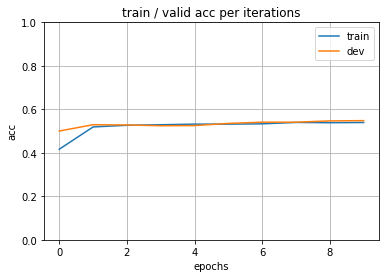

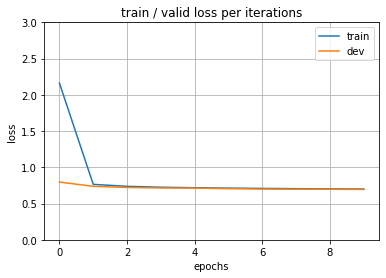

In [15]:
x_values1=np.arange(0, 10, 1)
x_values2=np.arange(0, 10, 1)
plt.plot(x_values1,useful_stuff['train_acc'], label = 'train')
plt.plot(x_values2,useful_stuff['valid_acc'], label = 'dev')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend()
plt.title('train / valid acc per iterations')
axes = plt.gca()
axes.set_ylim([0, 1])
plt.grid()
plt.show()

plt.plot(x_values1,useful_stuff['train_cost'], label = 'train')
plt.plot(x_values2,useful_stuff['valid_cost'], label = 'dev')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.title('train / valid loss per iterations')
axes = plt.gca()
axes.set_ylim([0, 3])
plt.grid()
plt.show()